## Classification Theory on cifar10 dataset
##### Tensorflow 2.2.0


In [1]:
import numpy as np #  provides a multidimensional array object
import matplotlib as plt # library for visualizations, graphs
import tensorflow as tf # machine learning framework
import matplotlib.pyplot as plt # graph plotting library
from sklearn.metrics import confusion_matrix # plotting tool for confususion matrix
import itertools # Functions creating iterators for efficient looping
import random # used to generate random numbers

In [2]:
# importing modules from tensorflow.keras to keep code readable
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam


In [3]:
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.2.0


### Varaibles

In [4]:
### Variables
PATH = "/home/michael/DataSciMSc/comp1801-ML/coursework/tests" # parent folder to save all data
MODEL_NAME = "005_6Conv_3Dense_Adam_DG" # name of model

# used for the dataset to change the numerical system
# to a named labelling system
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()


### Hyperparameters

In [5]:
USE_DATA_GENERATOR = False # bool used to switch between using data generator during training
BATCH_SIZE = 64 # batch size to pass while training
EPOCS = 10 # number of epochs to run
ACTIVATION_LAYER = "relu"  # activation function
ACTIVATION_OUTPUT = "softmax" # output activation function
OPTIMIZER = Adam(lr=0.0001) # optimiser
LOSS = "categorical_crossentropy" # loss function

#### Creating directories

In [6]:
# creating directories for images and models to be saved
import os

# Model data files
if not os.path.exists('%s/Model_Data/%s' %(PATH, MODEL_NAME)):
    os.makedirs('%s/Model_Data/%s' %(PATH, MODEL_NAME))
    print("***\nNew model directory created\n***")
else:
    print("***\nModel directory already present\n***")
    
# dataset files
if not os.path.exists('%s/dataset'%(PATH)):
    os.makedirs('%s/dataset'%(PATH))
    print("***\nNew dataset directory created\n***")
else:
    print("***\nDataset directory already present\n***")

***
Model directory already present
***
***
Dataset directory already present
***


## Functions that are used throughout the program

In [7]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    frequencies = np.sum(numpy_data, axis=0)
    
    return frequencies

In [8]:
# function to print out values for dataset
def array_values(image_array, labal_array, data_set):
    print("%s Image values:" % data_set)
    print('Image values (min to max):', np.min(image_array), 'to', np.max(image_array))
    print('Label values (min to max):', np.min(labal_array), 'to', np.max(labal_array))
    if(data_set == "Training"):
        data = "train"
    else:
        data = "test"
    print("X_{0} shape: {1}".format(data, image_array.shape))
    print("y_{0} shape: {1}".format(data, labal_array.shape))
    print('Total samples per class:', np.sum(labal_array, axis=0))

In [9]:
# function used to normalize arrays to values between 0 and 1
def normalise_data(array):
    output = array.astype("float32") / 255
    return output

In [10]:
# function for one hot encoding
def one_hot(array):
    output = tf.keras.utils.to_categorical(array)
    return output

In [11]:
# function takes numpy array and checks unique element count, returns array
def count_freq(numpy_data):
    (unique, counts) = np.unique(numpy_data, return_counts=True)
    frequencies = np.asarray((unique, counts)).T   # hold the frequency of each value
    return frequencies    

In [12]:
# function takes in numpy array and string, output bar graphs showing 
# distribution of training and testing data
def plot_freq(frequency, title):
    #labels = frequency[:,0] # labels for x axis
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1]) # axes is absolute coordinates on plot
    
    ax.bar(frequency[0:10, 0],frequency[0:10, 1]) # x and y axis for plot
    plt.xticks(frequency[0:10, 0], labels, rotation = 45) # define the x labels
    plt.title(title) # title
    plt.xlabel("Class") # x axis label
    plt.ylabel("Number of images")# y axis label
    # loop to get frequency data and display on chart
    for index,data in enumerate(frequency[0:10, 1]):
        # position the text data 
        plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10),ha="center")
    if not os.path.exists("%s/Images/%s.png"% (PATH,title)):
        plt.savefig("%s/Images/%s.png"% (PATH,title),bbox_inches='tight')

In [13]:
# plot history graphs from model training
def plot_history_graphs(data1, data2):
    plt.plot(history.history[data1], label = data1)
    plt.plot(history.history[data2], label = data2)
    plt.grid(True)
    plt.tight_layout()
    plt.title('Model %s'%data1)
    plt.ylabel(data1)
    plt.xlabel("Epoch")
    plt.legend()
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,data1)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,data1))

In [14]:
# function to plot random images from the dataset
def image_plot(Image_array, Label_array, Cols, Classes = 10, title = "Data Visulisation"):
    image_array = Image_array # image array
    label_array = Label_array # label array
    cols = Cols # number of columns for visulisation
    num_classes = Classes # classes 
    num_of_samples = [] # empty list
 
    # figure formatting
    fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(cols,num_classes))
    fig.tight_layout()

    # nested for loops to generate multiple images from data set
    for i in range(cols):
        for j in range(num_classes):
          x_selected = image_array[label_array == j]
          axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
          axs[j][i].axis("off")
          if i == 2:
            axs[j][i].set_title(str(j))
            num_of_samples.append(x_selected)
    if not os.path.exists("%s/Images/%s.png"% (PATH,title)):
        plt.savefig("%s/Images/%s.png"% (PATH,title),bbox_inches='tight')

In [15]:
# plot a confusion matrix to see what is going on with 
# model prediction
def confusion_matrix_graph(cm, classes,
                    title = "Confusion Matrix",
                    cmap = plt.cm.Blues):
    
    #cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], "d"),
        horizontalalignment = "center",
        color = "white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    if not os.path.exists("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,title)):
        plt.savefig("%s/Model_Data/%s/%s.png"% (PATH,MODEL_NAME,title))
    

### Load in cifar10 dataset

In [16]:
import pickle

"""
This function is used to check if a pkl file of the dataset has been previously 
downloaded. 
If there is an existing file, use this file as the dataset
else, use the TF api to download the dataset and save the dataset to local disk
"""

def load_cifar10():
    # check to see if the dataset has been saved as a pickle file
    if(os.path.isfile("%s/dataset/cifar10_data.pkl"%(PATH))):
        print("cifar10 data present.")
        with open("%s/dataset/cifar10_data.pkl"%(PATH),'rb') as f:
            cifar10 = pickle.load(f)
        print('cifar10 loaded from local file.')
    else:
        print("Data not present\nLoading from API\n")
        # load in data from keras datasets
        cifar10_data = tf.keras.datasets.cifar10
        # assign data to variables
        (X_train_raw, y_train_raw), (x_test_raw, y_test_raw) = cifar10_data.load_data()
        cifar10 = {
            "train_images": X_train_raw,
            "train_labels": y_train_raw,
            "test_images": x_test_raw,
            "test_labels": y_test_raw,
        }
        with open("%s/dataset/cifar10_data.pkl"%(PATH), "wb") as f:
            pickle.dump(cifar10, f)
        print("Data saved to local file")
    return cifar10


cifar10_data = load_cifar10()

print('\ncifar10 Train images (x): shape=', cifar10_data['train_images'].shape)
print("cifar10 Train image min/max values:",np.min(cifar10_data['train_images']), 'to',np.max(cifar10_data['train_images']))
print('cifar10 Train labels (y): shape=', cifar10_data['train_labels'].shape)
print("cifar10 Train label min/max values:",np.min(cifar10_data['train_labels']), 'to',np.max(cifar10_data['train_labels']))


print('\ncifar10 Test images (x): shape=', cifar10_data['test_images'].shape)
print("cifar10 Test image min/max values:",np.min(cifar10_data['test_images']), 'to',np.max(cifar10_data['test_images']))
print('cifar10 Test labels (y): shape=', cifar10_data['test_labels'].shape)
print("cifar10 Test label min/max values:",np.min(cifar10_data['test_labels']), 'to',np.max(cifar10_data['test_labels']))


         


cifar10 data present.
cifar10 loaded from local file.

cifar10 Train images (x): shape= (50000, 32, 32, 3)
cifar10 Train image min/max values: 0 to 255
cifar10 Train labels (y): shape= (50000, 1)
cifar10 Train label min/max values: 0 to 9

cifar10 Test images (x): shape= (10000, 32, 32, 3)
cifar10 Test image min/max values: 0 to 255
cifar10 Test labels (y): shape= (10000, 1)
cifar10 Test label min/max values: 0 to 9


### Nomalise data

In [17]:
print('Training image values before normalisation (min to max):', np.min(cifar10_data['train_images']), 'to', np.max(cifar10_data['train_images']))
print('Testing image values before normalisation (min to max):', np.min(cifar10_data['test_images']), 'to', np.max(cifar10_data['test_images']))
# nomalise image data
X_train = normalise_data(cifar10_data['train_images'])
x_test = normalise_data(cifar10_data['test_images'])
# check min/max
print('Training image values after normalisation (min to max):', np.min(X_train), 'to', np.max(X_train))
print('Testing image values after normalisation (min to max):', np.min(x_test), 'to', np.max(x_test))

Training image values before normalisation (min to max): 0 to 255
Testing image values before normalisation (min to max): 0 to 255
Training image values after normalisation (min to max): 0.0 to 1.0
Testing image values after normalisation (min to max): 0.0 to 1.0


In [18]:
# one hot encoding
y_train = one_hot(cifar10_data['train_labels'])
y_test = one_hot(cifar10_data['test_labels'])

### Compute properties

In [19]:
print(np.sum(y_train, axis=0))

[5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]


In [20]:
# check values of the training reshaped/nomalised arrays
array_values(X_train, y_train, "Training")   

Training Image values:
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
Total samples per class: [5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]


In [21]:
# check values for the testing reshaped/normalised arrays
array_values(x_test, y_test, "Testing")

Testing Image values:
Image values (min to max): 0.0 to 1.0
Label values (min to max): 0.0 to 1.0
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)
Total samples per class: [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


### Plot data

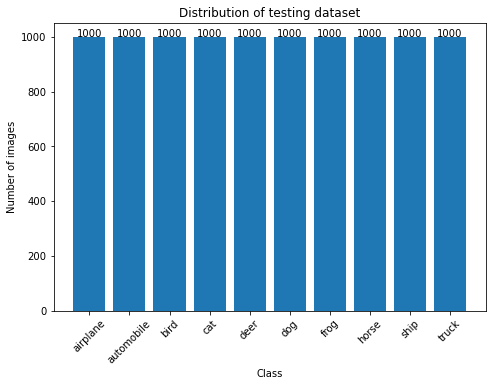

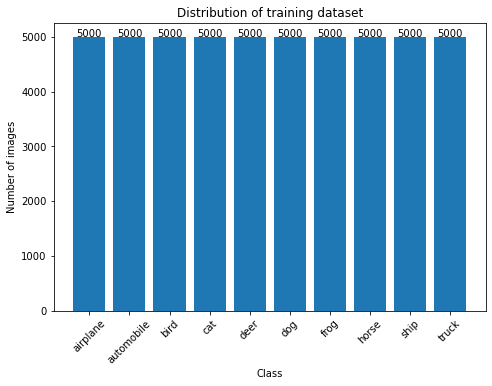

In [22]:
# testing data frequency
ax = plot_freq(count_freq(y_test.argmax(axis = 1)), "Distribution of testing dataset")    

# training data frequency
ax2 = plot_freq(count_freq(y_train.argmax(axis = 1)), "Distribution of training dataset")    
plt.show()


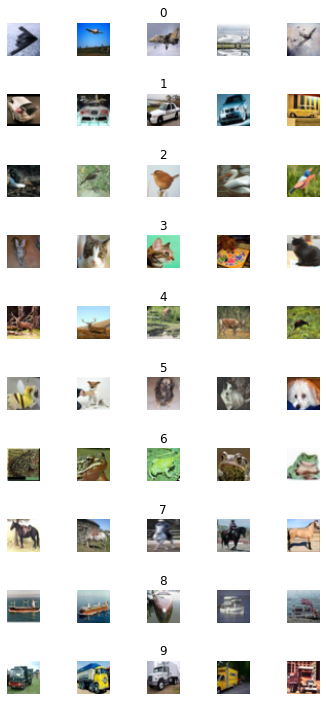

In [23]:
# visualise the dataset
image_plot(X_train, np.argmax(y_train, axis= 1), 5)

### Build tensorflow model using API method

In [24]:
# build model using tensorflow functional API
# first filter size = 3 * 3 * 3 * 32
first_layer = Input(shape = X_train[0].shape)

x = Conv2D(32, (3,3),  activation = ACTIVATION_LAYER, padding = "same")(first_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = ACTIVATION_LAYER, padding = "same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(1024, activation = ACTIVATION_LAYER)(x)
x = Dropout(0.6)(x)

x = Dense(10, activation=ACTIVATION_OUTPUT)(x)

In [25]:
model = Model(first_layer, x)

In [26]:
model.compile(optimizer = OPTIMIZER,
              loss = LOSS,
              metrics = ("accuracy")
             )

In [27]:
from contextlib import redirect_stdout
if not os.path.exists('%s/Model_Data/%s/modelsummary.txt' %(PATH, MODEL_NAME)):
    with open('%s/Model_Data/%s/modelsummary.txt' %(PATH, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            model.summary()
            print("Summary Written.")
else:
    print("Summary already saved.")
model.summary()

Summary already saved.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16

In [28]:
## preprocess data on the fly using keras ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range = 90, # Int. Degree range for random rotations.
    width_shift_range = 0.1, #float: fraction of total width, if < 1, or pixels if >= 1.
    height_shift_range = 0.1,
    horizontal_flip = True #Boolean. Randomly flip inputs horizontally.
    )

In [29]:
# calculate the number of steps while generating data to iterate over entire dataset
# using floor division
STEPS_PER_EPOC = (X_train.shape[0] // BATCH_SIZE)
# call to data generator
train_generator = data_generator.flow(X_train,y_train, BATCH_SIZE)

In [30]:
# fit model

if(USE_DATA_GENERATOR == True):
    history = model.fit(train_generator, 
                                  steps_per_epoch = STEPS_PER_EPOC, 
                                  epochs = EPOCS,
                                  validation_data =(x_test, y_test),
                                   shuffle=True)
else:
    history = model.fit(X_train, y_train,
                        validation_data =(x_test, y_test),
                        epochs = EPOCS,
                           shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6831 - accuracy: 0.4195 - val_loss: 1.2920 - val_accuracy: 0.5498
Epoch 2/10
 480/1563 [========>.....................] - ETA: 3s - loss: 1.2855 - accuracy: 0.5364

KeyboardInterrupt: 

In [ ]:
val_loss = plot_history_graphs("loss", "val_loss")


In [ ]:
val_accuracy = plot_history_graphs("accuracy", "val_accuracy")


In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
score_output = print('Test loss: %s \nTest accuracy: %s' % (score[0], score[1]))

if not os.path.exists('%s/Model_Data/%s/evaluation_score.txt' %(PATH, MODEL_NAME)):
    with open('%s/Model_Data/%s/evaluation_score.txt' %(PATH, MODEL_NAME), 'w') as f:
        with redirect_stdout(f):
            print('Test loss: %s \nTest accuracy: %s' % (score[0], score[1]))
    print("Score Written.")
else:
    print("Score Already present")
score_output
 


In [ ]:
preditctions = model.predict(x_test).argmax(axis = 1)
cm = confusion_matrix(y_test.argmax(axis = 1), preditctions)


In [ ]:
#print confusion matrix
confusion_matrix_graph(cm, list(range(10)))

In [ ]:
## display misclassified examples
misclassified = np.where(preditctions != y_test.argmax(axis = 1))[0]
image = np.random.choice(misclassified)
plt.imshow(x_test[image], cmap="gray")
plt.axis('off')
plt.title("True label: %s | Predicted: %s" % (labels[y_test.argmax(axis = 1)[image]], labels[preditctions[image]]))

In [ ]:
# save model weights
if not os.path.exists("%s/Model_Data/%s/%s.h5" % (PATH,MODEL_NAME,MODEL_NAME)):
        model.save_weights("%s/Model_Data/%s/%s.h5" % (PATH,MODEL_NAME,MODEL_NAME))
